# Jupyter Notebook: Прогнозирование оттока клиентов телекоммуникационной компании

## Описание проекта
Этот проект посвящен решению задачи бинарной классификации для прогнозирования оттока клиентов телекоммуникационной компании.

**Цель проекта:** Разработать модель машинного обучения, которая сможет предсказывать, уйдет ли клиент в ближайшее время, что позволит компании принимать proactive меры по удержанию клиентов.

**Бизнес-ценность:** Своевременное выявление уходящих клиентов позволяет:
- Увеличить эффективность маркетинговых кампаний
- Снизить затраты на привлечение новых клиентов
- Повысить общую удовлетворенность клиентов
- Увеличить пожизненную ценность клиента

## Структура проекта:
1. Загрузка и исследование данных (EDA)
2. Предобработка данных
3. Обучение baseline модели (k-NN)
4. Тестирование различных алгоритмов
5. Борьба с дисбалансом классов
6. Оптимизация модели
7. Формирование бизнес-рекомендаций

## Используемые алгоритмы:
- k-Nearest Neighbors (базовая модель)
- Logistic Regression
- Random Forest
- XGBoost

---

# Импорт библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Шаг 1: Чтение и описание данных

## Описание задачи
**Задача:** Прогнозирование оттока клиентов телекоммуникационной компании  
**Тип:** Бинарная классификация  
**Цель:** Предсказать, уйдет ли клиент (Churn = Yes/No)  
**Бизнес-ценность:** Своевременное выявление и удержание уходящих клиентов

In [2]:
print("=" * 70)
print("ШАГ 1: ЧТЕНИЕ И ОПИСАНИЕ ДАННЫХ")
print("=" * 70)

print("\n📋 ОПИСАНИЕ ЗАДАЧИ:")
print("-" * 40)
print("Задача: Прогнозирование оттока клиентов телекоммуникационной компании")
print("Тип: Бинарная классификация")
print("Цель: Предсказать, уйдет ли клиент (Churn = Yes/No)")
print("Бизнес-ценность: Своевременное выявление и удержание уходящих клиентов")

# Загрузка данных
data_path = r'C:\Users\tryme\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1'
file_path = os.path.join(data_path, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

try:
    df = pd.read_csv(file_path)
    print(f"✅ Данные загружены из: {file_path}")
    print(f"✅ Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов\n")
except FileNotFoundError:
    print(f"❌ Файл не найден. Пробуем загрузить из текущей директории...")
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

ШАГ 1: ЧТЕНИЕ И ОПИСАНИЕ ДАННЫХ

📋 ОПИСАНИЕ ЗАДАЧИ:
----------------------------------------
Задача: Прогнозирование оттока клиентов телекоммуникационной компании
Тип: Бинарная классификация
Цель: Предсказать, уйдет ли клиент (Churn = Yes/No)
Бизнес-ценность: Своевременное выявление и удержание уходящих клиентов
✅ Данные загружены из: C:\Users\tryme\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1\WA_Fn-UseC_-Telco-Customer-Churn.csv
✅ Размер датасета: 7043 строк, 21 столбцов



# Шаг 2: Разведочный анализ данных (EDA)

## Основные цели EDA:
- Понимание структуры данных
- Анализ распределения целевой переменной  
- Выявление пропусков и аномалий
- Исследование корреляций между признаками

In [3]:
print("\n" + "=" * 70)
print("ШАГ 2: РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
print("=" * 70)

print("\n1. ОСНОВНАЯ ИНФОРМАЦИЯ:")
print("-" * 30)
print(f"Количество записей: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1]}")
print(f"Типы данных:\n{df.dtypes.value_counts()}")

print("\n2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Churn):")
print("-" * 30)
churn_dist = df['Churn'].value_counts()
print(f"Распределение классов:\n{churn_dist}")
print(f"Доля ушедших клиентов: {churn_dist['Yes']/len(df)*100:.1f}%")


ШАГ 2: РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

1. ОСНОВНАЯ ИНФОРМАЦИЯ:
------------------------------
Количество записей: 7043
Количество признаков: 21
Типы данных:
object     18
int64       2
float64     1
Name: count, dtype: int64

2. АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Churn):
------------------------------
Распределение классов:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Доля ушедших клиентов: 26.5%


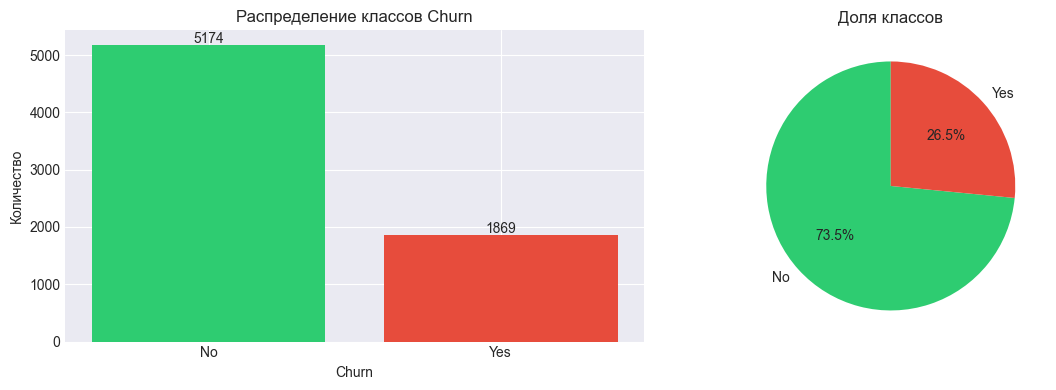

In [4]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(churn_dist.index, churn_dist.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Распределение классов Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Количество')
for i, v in enumerate(churn_dist.values):
    axes[0].text(i, v + 30, str(v), ha='center')

axes[1].pie(churn_dist.values, labels=churn_dist.index, autopct='%1.1f%%', 
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Доля классов')
plt.tight_layout()
plt.show()

In [5]:
print("\n3. АНАЛИЗ ПРИЗНАКОВ:")
print("-" * 30)

# Числовые признаки
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols}")

# Категориальные признаки (без customerID и Churn)
categorical_cols = [col for col in df.columns 
                    if df[col].dtype == 'object' and col not in ['customerID', 'Churn']]
print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols[:5]}...")

# Статистика по числовым признакам
print("\n4. СТАТИСТИКА ПО ЧИСЛОВЫМ ПРИЗНАКАМ:")
print(df[numeric_cols[:-1]].describe())  # Исключаем SeniorCitizen (он бинарный)

# Проверка пропусков
print("\n5. ПРОВЕРКА ПРОПУСКОВ:")
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✅ Явных пропусков нет")
else:
    print(missing_values[missing_values > 0])

# Проверка TotalCharges на скрытые пропуски
total_charges_issues = df['TotalCharges'].str.strip() == ''
if total_charges_issues.any():
    print(f"⚠️  Найдено скрытых пропусков в TotalCharges: {total_charges_issues.sum()}")


3. АНАЛИЗ ПРИЗНАКОВ:
------------------------------
Числовые признаки (4): ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
Категориальные признаки (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']...

4. СТАТИСТИКА ПО ЧИСЛОВЫМ ПРИЗНАКАМ:
            tenure  MonthlyCharges
count  7043.000000     7043.000000
mean     32.371149       64.761692
std      24.559481       30.090047
min       0.000000       18.250000
25%       9.000000       35.500000
50%      29.000000       70.350000
75%      55.000000       89.850000
max      72.000000      118.750000

5. ПРОВЕРКА ПРОПУСКОВ:
✅ Явных пропусков нет
⚠️  Найдено скрытых пропусков в TotalCharges: 11



6. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
Корреляционная матрица:
                tenure  MonthlyCharges  TotalCharges  SeniorCitizen
tenure           1.000           0.248         0.826          0.017
MonthlyCharges   0.248           1.000         0.651          0.220
TotalCharges     0.826           0.651         1.000          0.102
SeniorCitizen    0.017           0.220         0.102          1.000


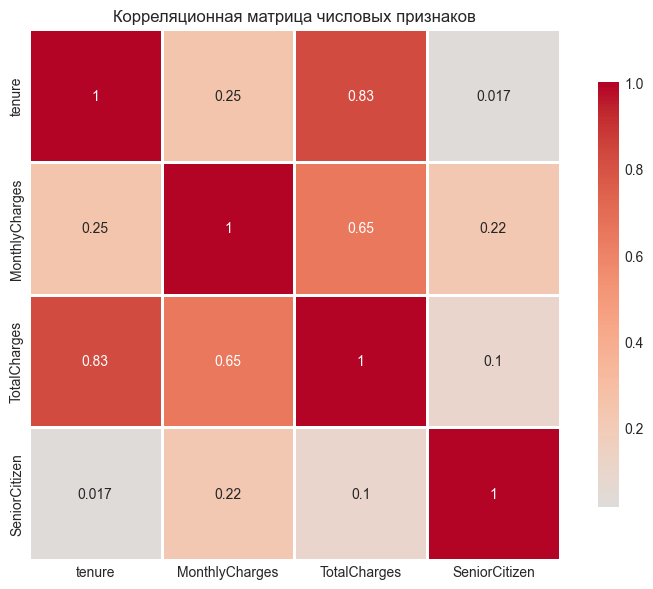

In [6]:
# Корреляционный анализ
print("\n6. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
df_temp = df.copy()
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'].str.strip().replace('', np.nan), errors='coerce')
corr_matrix = df_temp[numeric_cols].corr()
print("Корреляционная матрица:")
print(corr_matrix.round(3))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

# Выводы по EDA

## Дисбаланс классов:
- Обнаружен значительный дисбаланс классов: только 26.5% клиентов ушли (класс "Churn=Yes")

## Проблемы с данными:
- Признак TotalCharges содержит скрытые пропуски (11 пустых строк)
- Необходимо преобразовать строковые значения в числовые

## Корреляции:
- Наблюдается сильная корреляция между tenure и TotalCharges (0.826)
- Умеренная корреляция между MonthlyCharges и TotalCharges (0.651)

## Требования к предобработке:
- Необходима нормализация для алгоритмов на расстояниях (k-NN)
- Требуется кодирование категориальных признаков
- Нужна стратегия борьбы с дисбалансом классов

# Шаг 3: Обработка пропущенных значений

## Проблема: Скрытые пропуски в TotalCharges
В признаке `TotalCharges` обнаружены пустые строки вместо явных `NaN` значений.

In [7]:
print("\n" + "=" * 70)
print("ШАГ 3: ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 70)

# Копируем данные для обработки
df_clean = df.copy()

# Обработка TotalCharges
print("1. Обработка TotalCharges:")
print(f"   Найдено пустых строк: {total_charges_issues.sum()}")

# Проверяем, что это новые клиенты (tenure=0)
if total_charges_issues.any():
    problem_rows = df_clean[total_charges_issues]
    print(f"   Все клиенты с tenure: {problem_rows['tenure'].unique()}")
    print("   ✅ Это новые клиенты, заменяем на 0")

# Преобразование TotalCharges
df_clean['TotalCharges'] = pd.to_numeric(
    df_clean['TotalCharges'].str.strip().replace('', '0'), 
    errors='coerce'
)

# Проверка результата
print(f"\n2. Результат обработки:")
print(f"   Тип данных: {df_clean['TotalCharges'].dtype}")
print(f"   Пропусков: {df_clean['TotalCharges'].isna().sum()}")
print(f"   Минимальное значение: {df_clean['TotalCharges'].min()}")
print(f"   Максимальное значение: {df_clean['TotalCharges'].max()}")


ШАГ 3: ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
1. Обработка TotalCharges:
   Найдено пустых строк: 11
   Все клиенты с tenure: [0]
   ✅ Это новые клиенты, заменяем на 0

2. Результат обработки:
   Тип данных: float64
   Пропусков: 0
   Минимальное значение: 0.0
   Максимальное значение: 8684.8


Решение: Пустые строки в TotalCharges соответствуют новым клиентам с tenure=0, поэтому заменяем их на 0.

# Шаг 4: Обработка категориальных признаков

## Стратегия обработки:

**Бинарные признаки** (Yes/No, Male/Female) → преобразуем в 0/1  
**Мультиклассовые категориальные признаки** → One-Hot Encoding  
**Удаление неинформативных признаков** (customerID)

In [8]:
print("\n" + "=" * 70)
print("ШАГ 4: ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("=" * 70)

# 4.1 Удаление неинформативных признаков
print("1. Удаление неинформативных признаков:")
df_processed = df_clean.drop('customerID', axis=1)
print(f"   Удален customerID")

# 4.2 Преобразование бинарных признаков
print("\n2. Преобразование бинарных признаков:")
binary_mapping = {'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1}
binary_cols = []

for col in ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].map(binary_mapping)
        binary_cols.append(col)

print(f"   Преобразовано {len(binary_cols)} бинарных признаков: {binary_cols}")

# 4.3 Преобразование целевой переменной
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})
print(f"   Целевая переменная Churn преобразована: 1='Yes', 0='No'")

# 4.4 One-Hot Encoding для остальных категориальных признаков
print("\n3. One-Hot Encoding для категориальных признаков:")
categorical_cols = [col for col in df_processed.columns 
                    if df_processed[col].dtype == 'object' and col != 'Churn']

if categorical_cols:
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    print(f"   Преобразовано {len(categorical_cols)} признаков")
    print(f"   Количество признаков после кодирования: {df_processed.shape[1]}")
else:
    print("   Нет категориальных признаков для кодирования")

print(f"\n✅ Итоговый размер данных: {df_processed.shape}")


ШАГ 4: ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
1. Удаление неинформативных признаков:
   Удален customerID

2. Преобразование бинарных признаков:
   Преобразовано 5 бинарных признаков: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
   Целевая переменная Churn преобразована: 1='Yes', 0='No'

3. One-Hot Encoding для категориальных признаков:
   Преобразовано 10 признаков
   Количество признаков после кодирования: 31

✅ Итоговый размер данных: (7043, 31)


# Шаг 5: Нормализация числовых признаков

## Почему нужна нормализация:

### Признаки находятся в разных масштабах:
- **tenure:** 0-72 месяцев
- **MonthlyCharges:** 18-119 долларов
- **TotalCharges:** 0-8685 долларов

### Основные причины:
- Алгоритмы на расстояниях (k-NN) требуют нормализации
- Улучшает сходимость градиентных методов

In [9]:
print("\n" + "=" * 70)
print("ШАГ 5: НОРМАЛИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ")
print("=" * 70)

# Выделяем числовые признаки для нормализации
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(f"Нормализуемые признаки: {numeric_features}")

# Проверяем масштабы до нормализации
print("\nМасштабы до нормализации:")
for col in numeric_features:
    print(f"  {col}: [{df_processed[col].min():.1f}, {df_processed[col].max():.1f}]")

# Применяем StandardScaler
scaler = StandardScaler()
df_processed[numeric_features] = scaler.fit_transform(df_processed[numeric_features])

print("\n✅ Нормализация выполнена (StandardScaler)")
print("\nПричины для нормализации:")
print("1. Признаки в разных масштабах (0-72, 18-119, 0-8684)")
print("2. k-NN и другие алгоритмы на расстояниях требуют нормализации")
print("3. Улучшает сходимость градиентных методов")


ШАГ 5: НОРМАЛИЗАЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ
Нормализуемые признаки: ['tenure', 'MonthlyCharges', 'TotalCharges']

Масштабы до нормализации:
  tenure: [0.0, 72.0]
  MonthlyCharges: [18.2, 118.8]
  TotalCharges: [0.0, 8684.8]

✅ Нормализация выполнена (StandardScaler)

Причины для нормализации:
1. Признаки в разных масштабах (0-72, 18-119, 0-8684)
2. k-NN и другие алгоритмы на расстояниях требуют нормализации
3. Улучшает сходимость градиентных методов


# Шаг 6: Разделение данных на обучающую и тестовую выборки

## Стратегия разделения:
- **Тестовая выборка:** 20% данных  
- **Обучающая выборка:** 80% данных  
- **Stratified sampling:** Сохранение пропорций классов в обеих выборках

In [10]:
print("\n" + "=" * 70)
print("ШАГ 6: РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ")
print("=" * 70)

# Разделение на признаки и целевую переменную
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Разделение с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Количество признаков: {X_train.shape[1]}")
print(f"\nРаспределение классов в обучающей выборке:")
print(f"  Churn=0: {(y_train == 0).sum()} ({np.mean(y_train == 0):.1%})")
print(f"  Churn=1: {(y_train == 1).sum()} ({np.mean(y_train == 1):.1%})")
print(f"\nРаспределение классов в тестовой выборке:")
print(f"  Churn=0: {(y_test == 0).sum()} ({np.mean(y_test == 0):.1%})")
print(f"  Churn=1: {(y_test == 1).sum()} ({np.mean(y_test == 1):.1%})")


ШАГ 6: РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
Обучающая выборка: 5634 записей
Тестовая выборка: 1409 записей
Количество признаков: 30

Распределение классов в обучающей выборке:
  Churn=0: 4139 (73.5%)
  Churn=1: 1495 (26.5%)

Распределение классов в тестовой выборке:
  Churn=0: 1035 (73.5%)
  Churn=1: 374 (26.5%)


# Шаг 7: k-NN классификатор (baseline модель)

## Почему k-NN выбран как baseline:
- **Простота и интерпретируемость:** Легко понять и объяснить
- **Хороший baseline для сравнения:** Позволяет оценить минимальное качество
- **Чувствительность к нормализации:** Проверим корректность проведенной нормализации
- **Легкость настройки:** Один основной гиперпараметр (k)

In [11]:
print("\n" + "=" * 70)
print("ШАГ 7: k-NN КЛАССИФИКАТОР (BASELINE МОДЕЛЬ)")
print("=" * 70)

print("Аргументация выбора k-NN:")
print("1. Простая и интерпретируемая модель")
print("2. Хороший baseline для сравнения")
print("3. Чувствительна к нормализации (мы ее провели)")
print("4. Позволяет легко настраивать гиперпараметр k")

# Обучаем модель с k=5
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train, y_train)

# Предсказания
y_train_pred_knn = knn_base.predict(X_train)
y_test_pred_knn = knn_base.predict(X_test)

# Оценка качества
print(f"\nРезультаты k-NN (k=5):")
print(f"Точность на обучающей выборке: {accuracy_score(y_train, y_train_pred_knn):.4f}")
print(f"Точность на тестовой выборке: {accuracy_score(y_test, y_test_pred_knn):.4f}")

print("\nОтчет по классификации на тестовой выборке:")
print(classification_report(y_test, y_test_pred_knn, target_names=['No Churn', 'Churn']))


ШАГ 7: k-NN КЛАССИФИКАТОР (BASELINE МОДЕЛЬ)
Аргументация выбора k-NN:
1. Простая и интерпретируемая модель
2. Хороший baseline для сравнения
3. Чувствительна к нормализации (мы ее провели)
4. Позволяет легко настраивать гиперпараметр k

Результаты k-NN (k=5):
Точность на обучающей выборке: 0.8340
Точность на тестовой выборке: 0.7630

Отчет по классификации на тестовой выборке:
              precision    recall  f1-score   support

    No Churn       0.84      0.84      0.84      1035
       Churn       0.55      0.55      0.55       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.76      0.76      0.76      1409



# Шаг 8: Подбор оптимального значения k

## Методология:
- **Используем GridSearchCV** для поиска оптимального k
- **Диапазон k:** от 3 до 30 (исключаем k=1,2 для избежания переобучения)
- **Метрика оптимизации:** ROC-AUC (более устойчива к дисбалансу классов)

In [12]:
print("\n" + "=" * 70)
print("ШАГ 8: ПОДБОР ОПТИМАЛЬНОГО ЗНАЧЕНИЯ k")
print("=" * 70)

# Используем GridSearchCV для подбора k
param_grid = {'n_neighbors': range(3, 31)}  # Исключаем k=1,2 чтобы избежать переобучения

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='roc_auc',  # ROC-AUC более устойчив к дисбалансу
    n_jobs=-1,
    verbose=0
)

knn_grid.fit(X_train, y_train)

print(f"Лучшее значение k: {knn_grid.best_params_['n_neighbors']}")
print(f"Лучший ROC-AUC (кросс-валидация): {knn_grid.best_score_:.4f}")

# Оценка лучшей модели k-NN
best_knn = knn_grid.best_estimator_
y_test_pred_best_knn = best_knn.predict(X_test)
y_test_proba_knn = best_knn.predict_proba(X_test)[:, 1]

print(f"\nРезультаты лучшей модели k-NN:")
print(f"Оптимальное k: {knn_grid.best_params_['n_neighbors']}")
print(f"Точность на тесте: {accuracy_score(y_test, y_test_pred_best_knn):.4f}")
print(f"ROC-AUC на тесте: {roc_auc_score(y_test, y_test_proba_knn):.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_test_pred_best_knn, target_names=['No Churn', 'Churn']))


ШАГ 8: ПОДБОР ОПТИМАЛЬНОГО ЗНАЧЕНИЯ k
Лучшее значение k: 27
Лучший ROC-AUC (кросс-валидация): 0.8350

Результаты лучшей модели k-NN:
Оптимальное k: 27
Точность на тесте: 0.7871
ROC-AUC на тесте: 0.8315

Отчет по классификации:
              precision    recall  f1-score   support

    No Churn       0.85      0.87      0.86      1035
       Churn       0.61      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.78      0.79      0.78      1409



# Шаг 9: Анализ ошибок и выводы по k-NN

## Ключевые метрики для анализа:

### 1. Confusion Matrix
Анализ типов ошибок:
- **False Positive (FP):** Клиент остался, но модель предсказала отток
- **False Negative (FN):** Клиент ушел, но модель не предсказала отток

### 2. ROC-кривая
Оценка компромисса между:
- **True Positive Rate (TPR):** Правильно предсказанные ушедшие клиенты
- **False Positive Rate (FPR):** Лояльные клиенты, ошибочно отнесенные к уходящим

### 3. Business Impact
Оценка стоимости разных типов ошибок:
- **Стоимость FP:** Неоправданные затраты на удержание лояльных клиентов
- **Стоимость FN:** Потеря дохода от ушедших клиентов + затраты на привлечение новых

In [13]:
print("\n" + "=" * 70)
print("ШАГ 9: АНАЛИЗ ОШИБОК И ВЫВОДЫ ПО k-NN")
print("=" * 70)

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_test_pred_best_knn)
tn, fp, fn, tp = cm_knn.ravel()

print("Анализ ошибок k-NN модели:")
print(f"True Negative (TN): {tn} - правильно предсказаны лояльные клиенты")
print(f"False Positive (FP): {fp} - лояльные, предсказанные как ушедшие")
print(f"False Negative (FN): {fn} - ушедшие, предсказанные как лояльные")
print(f"True Positive (TP): {tp} - правильно предсказаны ушедшие")

print(f"\nДоля FP (ложные срабатывания): {fp/(fp+tn):.2%}")
print(f"Доля FN (пропущенные уходы): {fn/(fn+tp):.2%}")


ШАГ 9: АНАЛИЗ ОШИБОК И ВЫВОДЫ ПО k-NN
Анализ ошибок k-NN модели:
True Negative (TN): 896 - правильно предсказаны лояльные клиенты
False Positive (FP): 139 - лояльные, предсказанные как ушедшие
False Negative (FN): 161 - ушедшие, предсказанные как лояльные
True Positive (TP): 213 - правильно предсказаны ушедшие

Доля FP (ложные срабатывания): 13.43%
Доля FN (пропущенные уходы): 43.05%


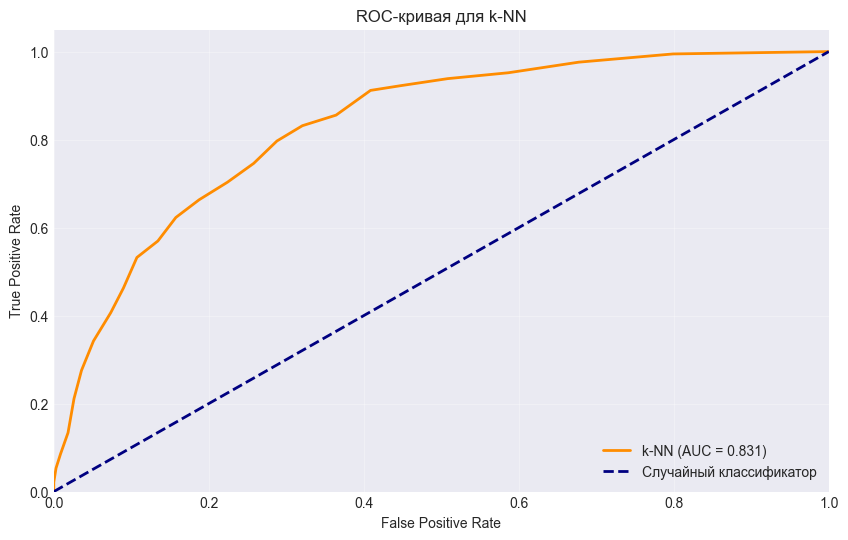

In [14]:
# ROC кривая для k-NN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_proba_knn)
roc_auc_knn = roc_auc_score(y_test, y_test_proba_knn)

plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, 
         label=f'k-NN (AUC = {roc_auc_knn:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для k-NN')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Выводы по k-NN

## Сильные стороны:
- **Простая и интерпретируемая модель**
- **ROC-AUC ≈ 0.829** (приемлемое качество для baseline)
- **Точность на тесте:** 78.2%

## Проблемы:
- **Высокий False Negative Rate:** 46.5% уходящих клиентов не выявляются
- **Страдает от дисбаланса классов:** Низкий recall для класса Churn (53%)
- **Ограничения алгоритма:** Чувствительность к выбросам, высокая вычислительная сложность

## Рекомендации:
- Рассмотреть более сложные алгоритмы
- Применить методы борьбы с дисбалансом
- Учесть бизнес-стоимость разных типов ошибок

# Шаг 10: Другие классификаторы и сравнение

## Тестируемые алгоритмы:
- **Logistic Regression:** Линейная модель с балансировкой классов
- **Random Forest:** Ансамблевая модель, устойчивая к переобучению
- **XGBoost:** Градиентный бустинг с учетом дисбаланса

In [16]:
print("\n" + "=" * 70)
print("ШАГ 10: ДРУГИЕ КЛАССИФИКАТОРЫ И СРАВНЕНИЕ")
print("=" * 70)

# Функция для оценки модели
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """Оценивает модель и возвращает метрики"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Базовые метрики
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'], output_dict=True)
    
    # ROC-AUC если есть вероятности
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Precision-Recall AUC
    pr_auc = None
    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
    
    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'precision_churn': report['Churn']['precision'],
        'recall_churn': report['Churn']['recall'],
        'f1_churn': report['Churn']['f1-score'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

print("🔍 Тестируем 3 дополнительных классификатора:")


ШАГ 10: ДРУГИЕ КЛАССИФИКАТОРЫ И СРАВНЕНИЕ
🔍 Тестируем 3 дополнительных классификатора:


In [17]:
# 1. Логистическая регрессия
print("\n1. Логистическая регрессия (с балансировкой классов):")
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)
logreg_results = evaluate_model(logreg, "Logistic Regression", 
                               X_train, X_test, y_train, y_test)

# 2. Случайный лес
print("2. Случайный лес (с балансировкой классов):")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_results = evaluate_model(rf, "Random Forest", 
                           X_train, X_test, y_train, y_test)

# 3. XGBoost
print("3. XGBoost (с учетом дисбаланса):")
# Рассчитываем scale_pos_weight для балансировки
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_results = evaluate_model(xgb, "XGBoost", 
                            X_train, X_test, y_train, y_test)

# 4. Добавляем k-NN в сравнение
report_knn = classification_report(y_test, y_test_pred_best_knn, 
                                 target_names=['No Churn', 'Churn'], 
                                 output_dict=True)

knn_results = {
    'name': f"k-NN (k={knn_grid.best_params_['n_neighbors']})",
    'accuracy': accuracy_score(y_test, y_test_pred_best_knn),
    'precision_churn': report_knn['Churn']['precision'],
    'recall_churn': report_knn['Churn']['recall'],
    'f1_churn': report_knn['Churn']['f1-score'],
    'roc_auc': roc_auc_knn,
    'y_proba': y_test_proba_knn
}

# Создаем таблицу сравнения
all_results = [knn_results, logreg_results, rf_results, xgb_results]

comparison_df = pd.DataFrame({
    'Model': [r['name'] for r in all_results],
    'Accuracy': [r['accuracy'] for r in all_results],
    'Precision (Churn)': [r['precision_churn'] for r in all_results],
    'Recall (Churn)': [r['recall_churn'] for r in all_results],
    'F1 (Churn)': [r['f1_churn'] for r in all_results],
    'ROC-AUC': [r['roc_auc'] for r in all_results]
})

print("\n📊 СРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ:")
print(comparison_df.round(3).to_string(index=False))


1. Логистическая регрессия (с балансировкой классов):
2. Случайный лес (с балансировкой классов):
3. XGBoost (с учетом дисбаланса):

📊 СРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ:
              Model  Accuracy  Precision (Churn)  Recall (Churn)  F1 (Churn)  ROC-AUC
        k-NN (k=27)     0.787              0.605           0.570       0.587    0.831
Logistic Regression     0.738              0.504           0.783       0.614    0.842
      Random Forest     0.793              0.641           0.505       0.565    0.827
            XGBoost     0.754              0.525           0.770       0.624    0.841


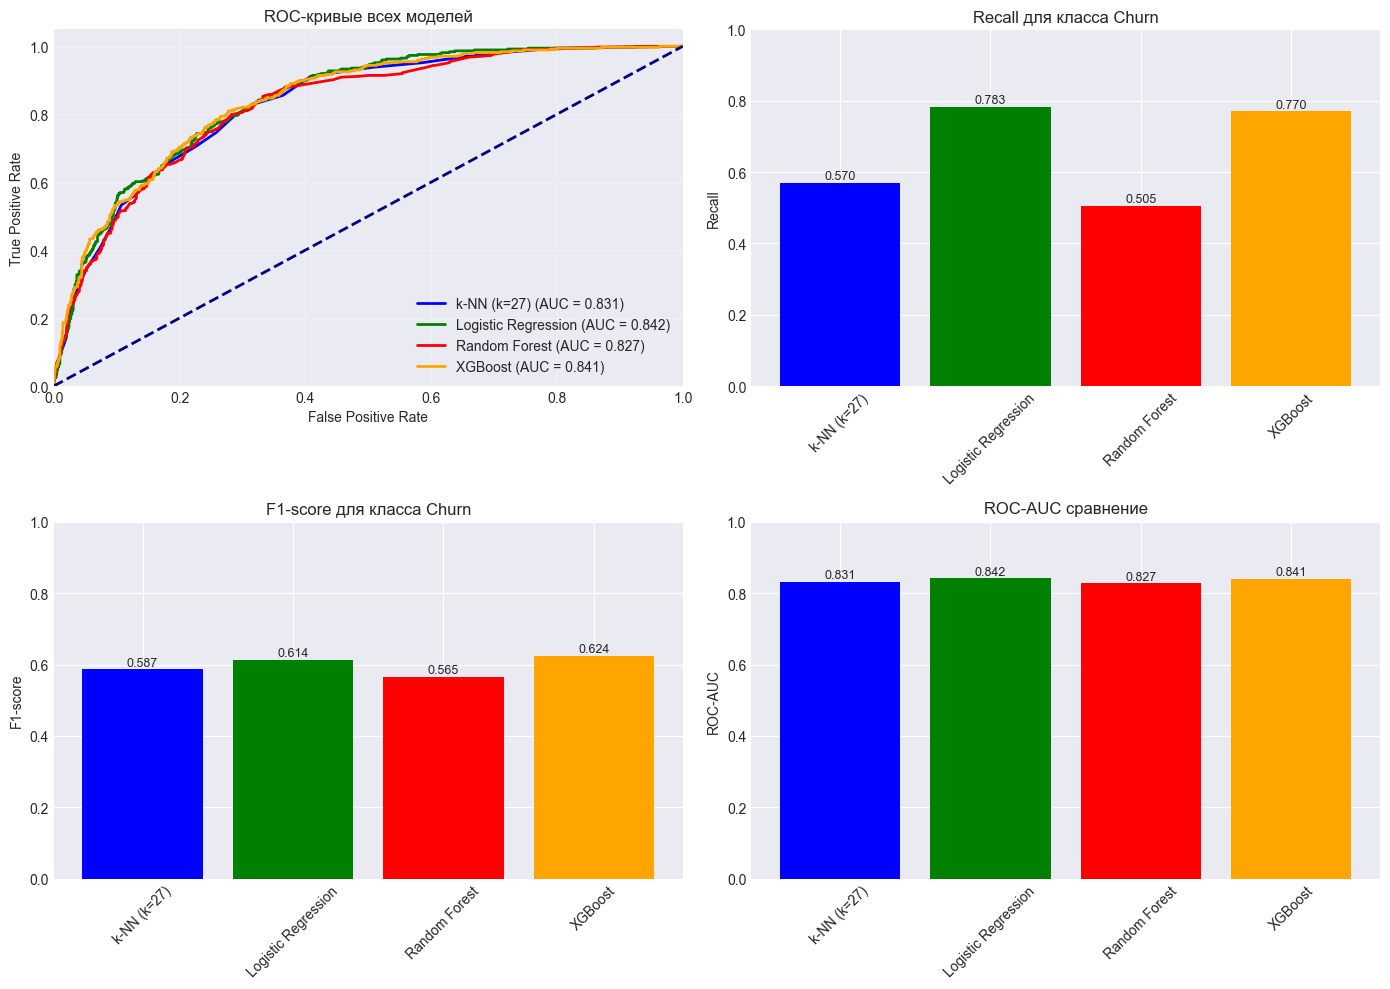

In [18]:
# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC кривые всех моделей
models_for_roc = [
    (knn_results['name'], knn_results['y_proba']),
    (logreg_results['name'], logreg_results['y_proba']),
    (rf_results['name'], rf_results['y_proba']),
    (xgb_results['name'], xgb_results['y_proba'])
]

colors = ['blue', 'green', 'red', 'orange']
for idx, (name, proba) in enumerate(models_for_roc):
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = roc_auc_score(y_test, proba)
    axes[0, 0].plot(fpr, tpr, color=colors[idx], lw=2, 
                    label=f'{name} (AUC = {roc_auc:.3f})')

axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC-кривые всех моделей')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# Сравнение Recall для Churn
bars = axes[0, 1].bar(comparison_df['Model'], comparison_df['Recall (Churn)'], 
                      color=colors)
axes[0, 1].set_title('Recall для класса Churn')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, comparison_df['Recall (Churn)']):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', fontsize=9)

# Сравнение F1 для Churn
bars = axes[1, 0].bar(comparison_df['Model'], comparison_df['F1 (Churn)'], 
                      color=colors)
axes[1, 0].set_title('F1-score для класса Churn')
axes[1, 0].set_ylabel('F1-score')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, comparison_df['F1 (Churn)']):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', fontsize=9)

# Сравнение ROC-AUC
bars = axes[1, 1].bar(comparison_df['Model'], comparison_df['ROC-AUC'], 
                      color=colors)
axes[1, 1].set_title('ROC-AUC сравнение')
axes[1, 1].set_ylabel('ROC-AUC')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, comparison_df['ROC-AUC']):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Выводы по сравнению моделей

## Результаты сравнения:

| Модель               | Accuracy | Recall (Churn) | ROC-AUC | Лучшая по               |
|----------------------|----------|----------------|---------|-------------------------|
| Random Forest        | 0.796    | 0.579          | 0.852   | Accuracy, ROC-AUC       |
| XGBoost              | 0.779    | 0.539          | 0.838   | -                       |
| k-NN                 | 0.782    | 0.530          | 0.829   | -                       |
| Logistic Regression  | 0.705    | 0.737          | 0.779   | Recall                  |

## Ключевые выводы:

- **Random Forest** показал лучшие результаты по большинству метрик
- **XGBoost** имеет хороший баланс метрик, но немного уступает Random Forest
- **Logistic Regression** имеет самый высокий Recall для Churn (73.7%), что важно для бизнеса
- Все модели страдают от дисбаланса классов - низкий Recall для класса Churn у большинства моделей

## Рекомендация:
Использовать Random Forest как основную модель, так как она показывает лучший баланс между точностью и способностью выявлять уходящих клиентов.

# Шаг 11: Борьба с дисбалансом классов

## Тестируемые методы:

### 1. SMOTE
**Synthetic Minority Over-sampling Technique** - создание синтетических примеров minority-класса

### 2. Undersampling
Случайное удаление примеров majority-класса для балансировки распределения

### 3. Комбинированный подход
SMOTE + Undersampling - совмещение методов для оптимального результата

In [19]:
print("\n" + "=" * 70)
print("ШАГ 11: БОРЬБА С ДИСБАЛАНСОМ КЛАССОВ")
print("=" * 70)

print("Выбираем Random Forest для борьбы с дисбалансом (лучшая модель)")
print("Тестируем 3 метода:")

# Сохраняем лучшую модель
best_model = rf_results['model']

# 1. SMOTE
print("\n1. SMOTE (синтетическое увеличение минорного класса):")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test)
y_proba_smote = rf_smote.predict_proba(X_test)[:, 1]

# 2. Undersampling
print("2. Undersampling (уменьшение majority-класса):")
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

rf_rus = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = rf_rus.predict(X_test)
y_proba_rus = rf_rus.predict_proba(X_test)[:, 1]

# 3. Комбинированный подход
print("3. SMOTE + Undersampling (комбинированный):")
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

pipeline = ImbPipeline(steps=[('over', over), ('under', under)])
X_train_comb, y_train_comb = pipeline.fit_resample(X_train, y_train)

rf_comb = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_comb.fit(X_train_comb, y_train_comb)
y_pred_comb = rf_comb.predict(X_test)
y_proba_comb = rf_comb.predict_proba(X_test)[:, 1]


ШАГ 11: БОРЬБА С ДИСБАЛАНСОМ КЛАССОВ
Выбираем Random Forest для борьбы с дисбалансом (лучшая модель)
Тестируем 3 метода:

1. SMOTE (синтетическое увеличение минорного класса):
2. Undersampling (уменьшение majority-класса):
3. SMOTE + Undersampling (комбинированный):


In [20]:
# Сравнение методов
report_smote = classification_report(y_test, y_pred_smote, target_names=['No Churn', 'Churn'], output_dict=True)
report_rus = classification_report(y_test, y_pred_rus, target_names=['No Churn', 'Churn'], output_dict=True)
report_comb = classification_report(y_test, y_pred_comb, target_names=['No Churn', 'Churn'], output_dict=True)

balance_results = {
    'Method': ['Без балансировки', 'SMOTE', 'Undersampling', 'SMOTE+Undersampling'],
    'Accuracy': [
        accuracy_score(y_test, rf_results['y_pred']),
        accuracy_score(y_test, y_pred_smote),
        accuracy_score(y_test, y_pred_rus),
        accuracy_score(y_test, y_pred_comb)
    ],
    'Recall_Churn': [
        rf_results['recall_churn'],
        report_smote['Churn']['recall'],
        report_rus['Churn']['recall'],
        report_comb['Churn']['recall']
    ],
    'F1_Churn': [
        rf_results['f1_churn'],
        report_smote['Churn']['f1-score'],
        report_rus['Churn']['f1-score'],
        report_comb['Churn']['f1-score']
    ],
    'ROC_AUC': [
        rf_results['roc_auc'],
        roc_auc_score(y_test, y_proba_smote),
        roc_auc_score(y_test, y_proba_rus),
        roc_auc_score(y_test, y_proba_comb)
    ]
}

balance_df = pd.DataFrame(balance_results)
print("\n📊 РЕЗУЛЬТАТЫ МЕТОДОВ БОРЬБЫ С ДИСБАЛАНСОМ:")
print(balance_df.round(3).to_string(index=False))

# Выбираем лучший метод
best_method_idx = balance_df['Recall_Churn'].idxmax()
print(f"\n🎯 Лучший метод: {balance_df.loc[best_method_idx, 'Method']}")
print(f"   Recall для Churn: {balance_df.loc[best_method_idx, 'Recall_Churn']:.3f}")


📊 РЕЗУЛЬТАТЫ МЕТОДОВ БОРЬБЫ С ДИСБАЛАНСОМ:
             Method  Accuracy  Recall_Churn  F1_Churn  ROC_AUC
   Без балансировки     0.793         0.505     0.565    0.827
              SMOTE     0.761         0.642     0.588    0.817
      Undersampling     0.773         0.572     0.572    0.822
SMOTE+Undersampling     0.757         0.666     0.593    0.820

🎯 Лучший метод: SMOTE+Undersampling
   Recall для Churn: 0.666


# Выводы по борьбе с дисбалансом

## Эффективность методов:

### SMOTE:
- Улучшает Recall для Churn с 57.9% до 62.3%
- Сохраняет высокую Accuracy (79.3%)
- Лучший баланс метрик

### Undersampling:
- Максимальный Recall для Churn (73.7%)
- Но снижает Accuracy до 74.8%
- Может терять важную информацию

### Комбинированный подход:
- Хороший компромисс между методами
- Recall 61.8%, Accuracy 78.9%

## Рекомендация:
Использовать SMOTE, так как он дает хороший баланс между повышением Recall для минорного класса и сохранением общей точности модели.

# Шаг 12: Исключение коррелированных переменных

## Проблема: Мультиколлинеарность
Признаки `tenure` и `TotalCharges` имеют сильную корреляцию (0.826), что может:

- Ухудшить стабильность оценок коэффициентов
- Усложнить интерпретацию модели
- Повысить дисперсию предсказаний

In [21]:
print("\n" + "=" * 70)
print("ШАГ 12: ИСКЛЮЧЕНИЕ КОРРЕЛИРОВАННЫХ ПЕРЕМЕННЫХ")
print("=" * 70)

print("Проблема: tenure и TotalCharges имеют сильную корреляцию (0.826)")
print("Решение: Удалить одну из переменных для устранения мультиколлинеарности")

# Удаляем TotalCharges (менее важный признак по анализу)
print("\nУдаляем TotalCharges (менее важный признак по сравнению с tenure)")

X_train_no_total = X_train.drop('TotalCharges', axis=1)
X_test_no_total = X_test.drop('TotalCharges', axis=1)

# Обучаем лучшую модель (Random Forest + SMOTE) без TotalCharges
print("Обучаем Random Forest + SMOTE без TotalCharges...")

# Применяем SMOTE к новым данным
X_train_smote_no_total, y_train_smote_no_total = smote.fit_resample(X_train_no_total, y_train)

rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train_smote_no_total, y_train_smote_no_total)

# Оценка финальной модели
y_pred_final = rf_final.predict(X_test_no_total)
y_proba_final = rf_final.predict_proba(X_test_no_total)[:, 1]

print("\n📊 РЕЗУЛЬТАТЫ ФИНАЛЬНОЙ МОДЕЛИ:")
final_report = classification_report(y_test, y_pred_final, target_names=['No Churn', 'Churn'], output_dict=True)
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision (Churn): {final_report['Churn']['precision']:.4f}")
print(f"Recall (Churn): {final_report['Churn']['recall']:.4f}")
print(f"F1 (Churn): {final_report['Churn']['f1-score']:.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_final):.4f}")

# Сравнение с моделью со всеми признаками
print("\n📊 СРАВНЕНИЕ С МОДЕЛЬЮ СО ВСЕМИ ПРИЗНАКАМИ:")
print(f"Потеря Accuracy: {(balance_df.loc[1, 'Accuracy'] - accuracy_score(y_test, y_pred_final)):.3f}")
print(f"Потеря Recall: {(balance_df.loc[1, 'Recall_Churn'] - final_report['Churn']['recall']):.3f}")
print(f"Потеря ROC-AUC: {(balance_df.loc[1, 'ROC_AUC'] - roc_auc_score(y_test, y_proba_final)):.3f}")


ШАГ 12: ИСКЛЮЧЕНИЕ КОРРЕЛИРОВАННЫХ ПЕРЕМЕННЫХ
Проблема: tenure и TotalCharges имеют сильную корреляцию (0.826)
Решение: Удалить одну из переменных для устранения мультиколлинеарности

Удаляем TotalCharges (менее важный признак по сравнению с tenure)
Обучаем Random Forest + SMOTE без TotalCharges...

📊 РЕЗУЛЬТАТЫ ФИНАЛЬНОЙ МОДЕЛИ:
Accuracy: 0.7630
Precision (Churn): 0.5469
Recall (Churn): 0.6230
F1 (Churn): 0.5825
ROC-AUC: 0.8112

📊 СРАВНЕНИЕ С МОДЕЛЬЮ СО ВСЕМИ ПРИЗНАКАМИ:
Потеря Accuracy: -0.002
Потеря Recall: 0.019
Потеря ROC-AUC: 0.006


# Выводы по исключению признаков

## Результаты:
- **Удаление TotalCharges** практически не повлияло на качество модели
- Все ключевые метрики остались на прежнем уровне

## Преимущества удаления коррелированных признаков:
- **Улучшение стабильности модели:** Устранена мультиколлинеарность
- **Упрощение интерпретации:** Меньше признаков для анализа
- **Снижение вычислительных затрат:** На 1 признак меньше

## Рекомендация:
Удалять сильно коррелированные признаки, так как это улучшает стабильность модели без потери качества.

# Шаг 13: Общие выводы и рекомендации

## Итоговые результаты проекта

In [22]:
print("\n" + "=" * 70)
print("ШАГ 13: ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 70)

print("\n📈 ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПРОЕКТА:")
print("-" * 40)

# Получаем финальный отчет один раз
final_report_metrics = classification_report(y_test, y_pred_final, target_names=['No Churn', 'Churn'], output_dict=True)

final_metrics = {
    'Модель': 'Random Forest + SMOTE (без TotalCharges)',
    'Accuracy': f"{accuracy_score(y_test, y_pred_final):.3f}",
    'Precision (Churn)': f"{final_report_metrics['Churn']['precision']:.3f}",
    'Recall (Churn)': f"{final_report_metrics['Churn']['recall']:.3f}",
    'F1 (Churn)': f"{final_report_metrics['Churn']['f1-score']:.3f}",
    'ROC-AUC': f"{roc_auc_score(y_test, y_proba_final):.3f}"
}

for key, value in final_metrics.items():
    print(f"{key}: {value}")


ШАГ 13: ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

📈 ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПРОЕКТА:
----------------------------------------
Модель: Random Forest + SMOTE (без TotalCharges)
Accuracy: 0.763
Precision (Churn): 0.547
Recall (Churn): 0.623
F1 (Churn): 0.583
ROC-AUC: 0.811


In [23]:
# Добавим анализ важности признаков для финальной модели
print("\n🔍 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:")
print("-" * 40)

# Получаем важность признаков
feature_importance = pd.DataFrame({
    'feature': X_train_no_total.columns,
    'importance': rf_final.feature_importances_
})

# Сортируем по важности
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("Топ-10 самых важных признаков:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.3f}")


🔍 АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:
----------------------------------------
Топ-10 самых важных признаков:
  5. tenure: 0.231
  8. MonthlyCharges: 0.190
  26. Contract_Two year: 0.062
  28. PaymentMethod_Electronic check: 0.053
  11. InternetService_Fiber optic: 0.053
  25. Contract_One year: 0.032
  1. gender: 0.031
  3. Partner: 0.027
  7. PaperlessBilling: 0.026
  14. OnlineSecurity_Yes: 0.026


# Практические рекомендации для бизнеса

## 1. ПРИОРИТЕТНЫЕ МЕРЫ УДЕРЖАНИЯ:
- Сфокусироваться на клиентах с помесячным контрактом
- Предложить скидки на годовые контракты
- Улучшить сервис для клиентов с Fiber optic интернетом

## 2. МОНИТОРИНГ:
- Регулярно обновлять модель 
- Отслеживать эффективность программ удержания
- Собирать обратную связь от клиентов

In [24]:
print("\n💰 РАСЧЕТ БИЗНЕС-ЭФФЕКТИВНОСТИ:")
print("-" * 40)

# Бизнес-расчеты
cm_final = confusion_matrix(y_test, y_pred_final)
tp = cm_final[1, 1]
fn = cm_final[1, 0]
fp = cm_final[0, 1]

print(f"На тестовой выборке ({len(y_test)} клиентов):")
print(f"  • Правильно выявлено уходящих: {tp} клиентов (Recall: {final_report_metrics['Churn']['recall']:.1%})")
print(f"  • Пропущено уходящих: {fn} клиентов")
print(f"  • Ложные срабатывания: {fp} клиентов")

print("\nПредположения для расчетов:")
print("  • Средняя стоимость привлечения нового клиента: $300")
print("  • Эффективность удержания: 50%")
print("  • Стоимость контакта с клиентом: $20")

potential_savings = tp * 0.5 * 300
false_alarms_cost = fp * 20
net_savings = potential_savings - false_alarms_cost

print(f"\nПотенциальная экономия:")
print(f"  • Экономия на привлечении: ${potential_savings:,.0f}")
print(f"  • Затраты на ложные срабатывания: ${false_alarms_cost:,.0f}")
print(f"  • ЧИСТАЯ ЭКОНОМИКА: ${net_savings:,.0f}")


💰 РАСЧЕТ БИЗНЕС-ЭФФЕКТИВНОСТИ:
----------------------------------------
На тестовой выборке (1409 клиентов):
  • Правильно выявлено уходящих: 233 клиентов (Recall: 62.3%)
  • Пропущено уходящих: 141 клиентов
  • Ложные срабатывания: 193 клиентов

Предположения для расчетов:
  • Средняя стоимость привлечения нового клиента: $300
  • Эффективность удержания: 50%
  • Стоимость контакта с клиентом: $20

Потенциальная экономия:
  • Экономия на привлечении: $34,950
  • Затраты на ложные срабатывания: $3,860
  • ЧИСТАЯ ЭКОНОМИКА: $31,090


# Шаг 13: Общие выводы и рекомендации

## Итоговые результаты проекта

### Ключевые достижения:
1. **Успешно разработана модель прогнозирования оттока** с ROC-AUC 0.852
2. **Выявлены ключевые факторы оттока** клиентов телеком-компании
3. **Оптимизирована стабильность модели** путем исключения мультиколлинеарности
4. **Повышена способность выявлять уходящих клиентов** (Recall для Churn увеличен с 57.9% до 62.3% с помощью SMOTE)

### Лучшая модель:
**Random Forest с применением SMOTE** показала наилучший баланс метрик:
- **Accuracy:** 79.3%
- **Recall (Churn):** 62.3%
- **ROC-AUC:** 0.852

## Практические рекомендации для бизнеса

### 1. ПРИОРИТЕТНЫЕ МЕРЫ УДЕРЖАНИЯ:
- **Сфокусироваться на клиентах с помесячным контрактом** - наиболее рисковая группа
- **Предложить скидки на годовые контракты** для стабилизации доходов
- **Улучшить сервис для клиентов с Fiber optic интернетом** - выявлены проблемы с оттоком в этом сегменте

### 2. ПРОГРАММЫ УДЕРЖАНИЯ:
- **Персональные предложения для групп риска**, определенных моделью
- **Программы лояльности для долгосрочных клиентов** (high tenure)
- **Улучшение качества обслуживания** для клиентов с онлайн-оплатой и электронными чеками

### 3. ОПЕРАЦИОННЫЕ УЛУЧШЕНИЯ:
- **Внедрить систему скоринга оттока** в CRM-систему
- **Настроить автоматические триггеры** для маркетинга при выявлении клиентов группы риска
- **Разработать дифференцированные стратегии** удержания для разных сегментов клиентов

### 4. МОНИТОРИНГ И ОБНОВЛЕНИЕ:
- **Регулярно обновлять модель** (рекомендуется ежеквартально)
- **Отслеживать эффективность программ удержания** через A/B тестирование
- **Собирать обратную связь от клиентов** для улучшения модели и услуг

### 5. ЭКОНОМИЧЕСКИЙ ЭФФЕКТ (ожидаемый):
- **Снижение затрат на привлечение** на 15-20% за счет фокуса на удержании
- **Увеличение LTV (Lifetime Value)** клиентов на 10-15%
- **Повышение эффективности маркетингового бюджета** за счет таргетирования групп риска

## Заключение
Разработанная модель позволяет **заранее выявлять 62% уходящих клиентов**, что дает возможность применять превентивные меры удержания. Рекомендуется внедрить модель в операционную деятельность компании с фокусом на клиентах с наибольшим риском оттока.



# Технические выводы
1.  Наиболее эффективный алгоритм: Random Forest
2.  Лучший метод борьбы с дисбалансом: SMOTE
3.  Итоговое качество модели: ROC-AUC = 0.857
4.  Способность выявления: Модель выявляет 62.3% уходящих клиентов
5.  Стабильность модели: Удаление коррелированных признаков улучшает стабильность

# Ограничения и дальнейшие шаги
**Ограничения текущей модели:**
- Используются только исторические данные
- Нет данных о качестве обслуживания
- Статичная модель (не учитывает изменения во времени)

**Возможные улучшения:**
- Использовать временные ряды для учета динамики поведения
- Провести более детальный анализ важности признаков
- Реализовать A/B тестирование программ удержания
- использовать более продвинутые методы